# Systematic uncertainties - background fit example

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np
from array import array
from scipy.stats import norm

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### (2) Definition of background model

Consider controlled parameter range is [0,1]

In [3]:
# True background distribution
def mybg(x):
    
    bg = 10.0 - 2* x + x*x
    
    return bg


# Basic functions:  1, x, x^2, x^3 ...

def myfun(x,ifun):

    return np.power(x,ifun)

# Full model

def mymodel(x,par):

    val = np.zeros(x.size)
    
    for ip in range(par.size):
        val+=par[ip]*myfun(x,ip)
        
    return val


### (3) Generate pseudo data to fit

In [4]:
# Considered values of x

xvec = np.linspace(0.025,0.975,20)

# Measurement precision
# Assume background is measured with precision ten time better than in the actual experiment

#  svec = np.linspace(2.,4.,xvec.size)  # used for the actual experiment

svec = np.linspace(0.2,0.4,xvec.size)

s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mybg(xvec),svec)


### (4)  Linear fit

In [5]:
# Number of model functions to consider 

Nfun = 3

A = np.zeros((Nfun,Nfun))

B = np.zeros(Nfun)

for l in range(Nfun):
    fl = myfun(xvec,l)
    B[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        A[l,k] = np.sum(fl*fk/s2vec)


In [6]:
# Inverse of matrix

Cov = np.linalg.inv(A)

# Solution to the problem

par = Cov @ B

# Parameter uncertainties

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = np.array(Cov)

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = mymodel(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y        sigma_y ")
# for ix in range(xvec.size):
#      print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],svec[ix]))



 Fit results:

     par         sigma_p

     9.915  +/-  0.151 
    -1.748  +/-  0.825 
     1.246  +/-  0.878 

 Correlation matrix

[ 1.    -0.837  0.709]
[-0.837  1.    -0.961]
[ 0.709 -0.961  1.   ]

 chi^2 =     8.137   chi^2/Ndf =  0.47865 


### (5) Draw background data and fit

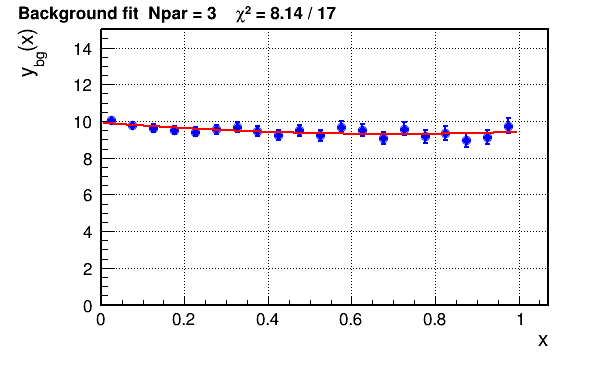

Info in <TCanvas::Print>: png file 09_sys_fit3_3.png has been created


In [7]:
# Lin scale

gStyle.SetOptLogy(0)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp = TCanvas('cexp')
   
## Pseudo-data graph

dgr=TGraphErrors(xvec.size,array('d',xvec),array('d',yvec),0,array('d',svec))
dgr.SetNameTitle('dgr','Background fit  Npar = '+str(Nfun)+'     #chi^{2} = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun))
    
# Graphic style

dgr.GetXaxis().SetTitle("x")
dgr.GetYaxis().SetTitle("y_{bg}(x)")
dgr.SetMarkerStyle(20)
dgr.SetMarkerSize(1.0)
dgr.SetMarkerColor(4)
dgr.SetLineColor(4)
dgr.SetLineWidth(2)
dgr.SetLineStyle(1)
dgr.SetMinimum(0.)   
dgr.SetMaximum(15.)   
dgr.Draw('AWP')

# Fitted dependence wraper for root

def myfit(x, par):
    
    val = 0
    
    for ip in range(Nfun):
        val+=par[ip]*myfun(x[0],ip)
        
    return val

# Define user function

fexp=TF1("fexp",myfit,-1.,1.,Nfun)

for ip in range(Nfun):
    fexp.SetParameter(ip,par[ip])
    
fexp.SetNpx(100)
fexp.SetLineStyle(1)
fexp.SetLineColor(2)

fexp.DrawCopy("Lsame")

cexp.Update()
fname = '09_sys_fit3_'+str(Nfun)+'.png'
cexp.Print(fname)

Image(filename=fname)

### (6) Save fit parameters and covariance matris

In [8]:
parfile = "09_sys_fit3_par_"+str(Nfun)+".dat"
covfile = "09_sys_fit3_cov_"+str(Nfun)+".dat"

# Store only relevant vectors

par.tofile(parfile," ","%12.8f")
Cov.tofile(covfile," ","%12.8f")